In [531]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [532]:
pip freeze > requirements.txt

In [533]:
!cat requirements.txt

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cachetools==5.2.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.8
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.1
datascience==0.17.5
db-dtypes==1.0.5
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
desc

In [534]:
import numpy as np
import random
import gym
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

%matplotlib inline

In [535]:
def make_env(env_name, seed=None):
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


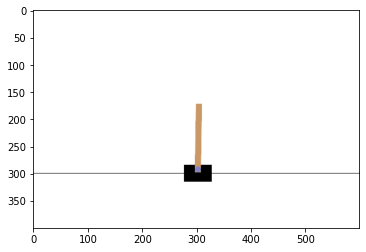

In [536]:
env_name = 'CartPole-v1'
env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, n_a_s = env.observation_space.shape, env.action_space.n

In [537]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [538]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_a_s, epsilon=0):
        super().__init__()
        self.epsilon = epsilon
        self.n_a_s = n_a_s
        self.state_shape = state_shape
        
        state_dim = state_shape[0]
        self.network = nn.Sequential()
        self.network.add_module('l_1', nn.Linear(state_dim, 64))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('l_2', nn.Linear(64, 128))
        self.network.add_module('relu2', nn.ReLU())
        self.network.add_module('l_3', nn.Linear(128, 64))
        self.network.add_module('relu3', nn.ReLU())
        self.network.add_module('l_4', nn.Linear(64, n_a_s))
        self.parameters = self.network.parameters
        
    def forward(self, state_t):
        q_vals = self.network(state_t)
        return q_vals

    def obtain_q_vals(self, s_s):
        s_s = torch.tensor(s_s, device=device, dtype=torch.float32)
        q_vals = self.forward(s_s)
        return q_vals.data.cpu().numpy()

    def sample_a_s(self, q_vals):
        epsilon = self.epsilon
        batch_size, n_a_s = q_vals.shape
        random_a_s = np.random.choice(n_a_s, size=batch_size)
        best_a_s = q_vals.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1 - epsilon, epsilon])
        return np.where(should_explore, random_a_s, best_a_s)

In [539]:
agent = DQNAgent(state_shape, n_a_s, epsilon=0.5).to(device)

In [540]:
def evaluate(env, agent, n_games=1, greedy=False, t_maximum=512):
    rst_rwd = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_maximum):
            q_vals = agent.obtain_q_vals([s])
            action = q_vals.argmax(axis=-1)[0]
            if greedy:
              pass
            else:
              agent.sample_a_s(q_vals)[0]
            s, r, done, _, _ = env.step(action)
            reward += r
            if done:
                break
        rst_rwd.append(reward)
    return np.mean(rst_rwd)

In [541]:
print(evaluate(env, agent, n_games=1))
env.close()

10.0


In [542]:
class ReplayBuffer:
    def __init__(self, size):
        self.next_id = 0
        self.size = size
        self.buffer =[]
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
           self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = list(self.buffer[i] for i in idxs)
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [543]:
def play_rec(stt_state, agent, env, exp_replay, n_steps=1):
    s = stt_state
    total_rwd_s = 0
    for _ in range(n_steps):
        q_vals = agent.obtain_q_vals([s])
        a = agent.sample_a_s(q_vals)[0]        
        next_state, r, done, _, _ = env.step(a)
        total_rwd_s += r
        exp_replay.add(s, a, r, next_state, done)
        if done:
            s = env.reset()
        else:
            s = next_state
        
    return total_rwd_s, s

In [544]:
t_n = DQNAgent(agent.state_shape, agent.n_a_s, epsilon=0.5).to(device)
t_n.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [545]:
def td_loss(agent, t_n, s_s, a_s, rwd_s, next_s_s, done_f_s, gamma=0.99, device=device):
    s_s = torch.tensor(s_s, device=device, dtype=torch.float)
    a_s = torch.tensor(a_s, device=device, dtype=torch.long)
    rwd_s = torch.tensor(rwd_s, device=device, dtype=torch.float)
    next_s_s = torch.tensor(next_s_s, device=device, dtype=torch.float)
    done_f_s = torch.tensor(done_f_s.astype('float32'),device=device,dtype=torch.float)

    predicted_q_vals = agent(s_s)
    predicted_next_q_vals = t_n(next_s_s)
    predicted_q_vals_for_a_s = predicted_q_vals[range(len(a_s)), a_s]
    next_state_vals, _ = torch.max(predicted_next_q_vals, dim=1)
    target_q_vals_for_a_s = rwd_s + gamma * next_state_vals * (1 - done_f_s)
    loss = torch.mean((predicted_q_vals_for_a_s - target_q_vals_for_a_s.detach()) ** 2)

    return loss

In [546]:
from tqdm import trange
from IPython.display import clear_output

In [547]:
seed = 64
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
print('seed is:', seed)

seed is: 64


In [548]:
env_name = 'CartPole-v1'
env = make_env(env_name, seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


<All keys matched successfully>

In [549]:
exp_replay = ReplayBuffer(10**3)
for i in range(100):
    play_rec(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**3:
        break

In [550]:
#parameters for training
timesteps_per_epoch = 1
batch_size = 64
total_steps = 2 * 10**4

#Choose Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-3)

#epsilon exploration 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**3

#target network logging and updating frequency
loss_freq = 16
refresh_target_network_freq = 64
eval_freq = 512

max_grad_norm = 4096

In [551]:
mean_rw_hist = []
td_loss_hist = []

In [552]:
def epsilon_sched(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps - start_eps) * min(step, final_step) / final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 1000, epsilon = 1.000000


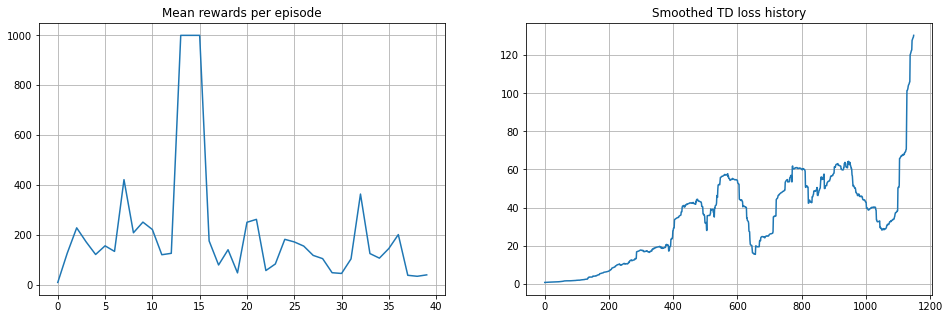

100%|██████████| 20001/20001 [01:32<00:00, 216.17it/s]


In [553]:
state = env.reset()

for step in trange(total_steps + 1):
    agent.eps = epsilon_sched(start_epsilon, end_epsilon, step, eps_decay_final_step)
    _, state = play_rec(state, agent, env, exp_replay, timesteps_per_epoch)
    s_s, a_s, rwd_s, next_s_s, done_f_s = exp_replay.sample(batch_size)

    loss = td_loss(agent, t_n, s_s, a_s, rwd_s, next_s_s, done_f_s, gamma=0.99, device=device)
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_hist.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        t_n.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_hist.append(evaluate(make_env(env_name, seed=step), agent, n_games=3, greedy=True, t_maximum=1000))

        clear_output(True)
        print("buffer size = %i, epsilon = %.6f" % (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean rewards per episode")
        plt.plot(mean_rw_hist)
        plt.grid()

        assert not np.isnan(td_loss_hist[-1])
        plt.subplot(1, 2, 2)
        plt.title('Smoothed TD loss history')
        plt.plot(smoothen(td_loss_hist))
        plt.grid()

        plt.show()

In [554]:
final_score = evaluate(make_env(env_name), agent, n_games=40, greedy=True, t_maximum=1000)
print('final score: ', final_score)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


final score:  43.55
